Here we will try to use technic Augmentation of data with combination of transfer learning

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

resolution = (128, 128)

#predprocess data 
directory = 'datasets'

train = image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = "int",
    class_names = None,
    color_mode = "rgb",
    batch_size = 32,
    image_size = resolution,
    seed = 100,
    crop_to_aspect_ratio = False,
    validation_split=0.1,
    subset="training",

)

valid = image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = "int",
    class_names = None,
    color_mode = "rgb",
    batch_size = 32,
    image_size = resolution,
    seed = 100,
    crop_to_aspect_ratio = False,
    validation_split=0.1,
    subset="validation",

)


Found 11302 files belonging to 8 classes.
Using 10172 files for training.
Found 11302 files belonging to 8 classes.
Using 1130 files for validation.


In [25]:
# Prefetch images to memory, to make training faster

AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)



In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [44]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = resolution + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [45]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
base_model.trainable = False

In [61]:
input_shape = tf.keras.Input(shape=(resolution[0],resolution[1], 3))
x = data_augmentation(input_shape)

## we want to get resolution of dataset imgs as was in pre-trained model
x =  tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

## preventing overfitiing
x = tf.keras.layers.Dropout(0.2)(x)

## this is layer is added because we want to our dataset classes == pretrained model outputs
outputs_shape = tf.keras.layers.Dense(8)(x)
model = tf.keras.Model(input_shape, outputs_shape)

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(), # lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
history = model.fit(train,
                    epochs=60,
                    validation_data=valid)

Epoch 1/60
 14/318 [>.............................] - ETA: 59s - loss: 1.9564 - accuracy: 0.3884 

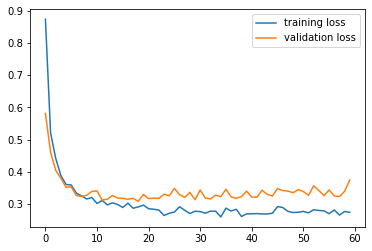

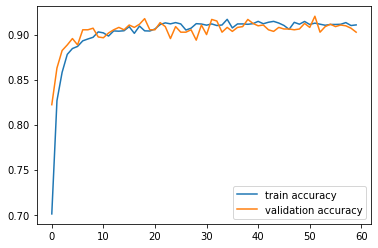

In [50]:
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

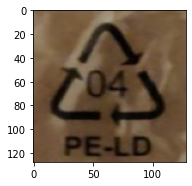

1/1 [==============================] - 0s 24ms/step
1 predicted


array([[-14.892208  ,   0.61820465,  -1.3011925 , -14.870197  ,
         -1.1098579 ,  -2.6903093 ,  -5.929673  ,  -1.6292124 ,
        -20.992908  ]], dtype=float32)

In [60]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_img(img_matrix):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    
    ax1.imshow(img_matrix.astype('uint8'))

    plt.show()

def get_result(prediction):
    return np.argmax(prediction)

def procces_img(path):
    img_tmp = Image.open(path).resize((resolution[0],resolution[1]))
    return np.array(img_tmp).astype('uint8')




img = procces_img('test/Screenshot 2023-01-17 113435.jpg')
plot_img(img)
prediction = model.predict(img.reshape((-1, 128, 128, 3)))
print(f'{get_result(prediction)} predicted' )
prediction